# Exploring the SVHN Data

### Importing neccessary libraries

In [256]:

import numpy as np
import scipy.io as sio

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

### Loading the test and training data

In [257]:
shiftTransform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=0,translate=(0.08,0.08)),
    torchvision.transforms.ToTensor()
    ])

In [258]:
train = torchvision.datasets.SVHN(root="data/", split="train", transform=shiftTransform)
test = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

### Preparing out data set

In [259]:
n_epochs = 25
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 32, 32])

In [260]:
# 6 layer Net (3 convolutional layers, 1 dropout layer, 2 linear layers)

# TODO : remove pooling... this might mean the inputs of some of the layers will need to be altered...
#        This will most likely mean editing the x = x.view() line to resize the data such that there 
#        will be a (1000,N) shape
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(14520, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_drop(self.conv3(x)), 2)  # can't pool because image will be too small
        x = x.view(-1, 14520)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [261]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [262]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [263]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [264]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [265]:
print(example_data.shape)
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

torch.Size([1000, 3, 32, 32])


/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_27810/607711756.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.2931, Accuracy: 5099/26032 (20%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.263970
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.290235
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.244715
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.268203
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.236074
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.241133
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.259520
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.269819
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.204431
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.248810
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.297256
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.243625
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.192908
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.237229
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.226821
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.289139
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.217262
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.312921
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.266129
Train Epoch: 1 [12160/7

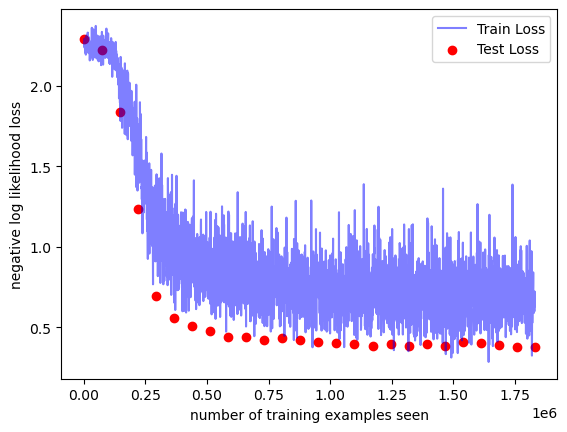

In [269]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', alpha=0.5)
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [267]:
with torch.no_grad():
  output = network(example_data)

/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_27810/607711756.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_27810/2502561851.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


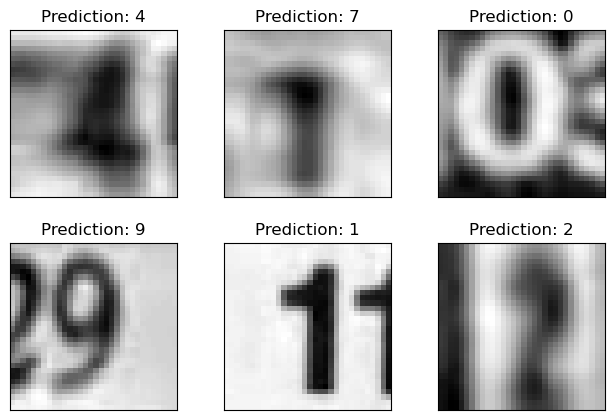

In [268]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()